In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv('Files/tracks_cleaned.csv')

In [4]:
df.sample(5)

,artist_id,artist_name,track_name,track_id,popularity,explicit,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration
10766,1J4CDjVHn8ummXVmJ7Q73u,Frankie Paul,Slow Down,2L4yRkFyGWpJ8a0maHsT5W,1,False,0.698,0.414,8.0,-11.530,0.0635,0.0223,0.0759,0.916,83.0,4.0,1.0,2020,3.662217
19446,6u7C6jxjkDAThmdcOnAwH0,Leroy Smart,Mine Field Dub,0ZmxNHPzzSkzrEDJhMPnap,0,False,0.751,0.561,7.0,-9.809,0.0473,0.3530,0.1400,0.896,146.0,4.0,0.0,2014,2.546000
24906,0oea1hwGMfUxZbLxJc1XUN,Peter Tosh,The Toughest - Live,32yyhKfWP2OVULiVfxje6u,9,False,0.619,0.514,7.0,-13.406,0.2290,0.0751,0.3240,0.255,188.0,4.0,1.0,2014,4.561550
33500,6taesTUSevB9eK8bm5Y7b9,Tony Matterhorn,Been Through It,5C9ov8z8H7rif9Fu4vcMvU,5,True,0.756,0.892,1.0,-3.495,0.2600,0.0268,0.0603,0.688,102.0,4.0,1.0,2018,2.078433
3963,6UuT0BJZ9vF8Y1sxXnJl2s,Bounty Killer,Down In The Ghetto,1L3gzXrLlQZKgomry7VKSp,0,False,0.825,0.719,10.0,-6.120,0.3930,0.4790,0.1990,0.836,168.0,4.0,0.0,2006,3.454667


## Functions

In [5]:
# One Hot Encoder Function
def one_hot_encode(multcolumns, final_df):
    """
    Expects: Features and the dataframe
    Return: Dataframe one hot encoded categorical columns
    """
    df_final=final_df
    i=0
    for fields in multcolumns:
        
        print(fields)
        df1=pd.get_dummies(final_df[fields],drop_first=True)
        
        final_df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1        
    df_final=pd.concat([final_df,df_final],axis=1)
        
    return df_final

In [6]:
# Determine the best number of clusters for KMeans
def k_optimizer(data, max_k):
    """
    Expects: Dataframe to apply KMeans, and the maximum value for k
    Return: returns a plot for the ks to manually determine the ideal k
    """
    
    means=[]
    inertia=[]
    
    # Model data with each k
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state=876)
        kmeans.fit(data)
        
        means.append(k)
        inertia.append(kmeans.inertia_)
        print(f'The innertia for {k} Clusters is: {kmeans.inertia_}')
    # Generate plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertia, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.xticks(means)
    plt.grid(True)
    plt.show()

In [7]:
# Get the number of values within each cluster
def cluster_count(cluster_list):
    """
    Expects: kmeand.labels_
    Return: Dataframe showing clusters and their sizes
    """
    unique, counts = np.unique(cluster_list, return_counts=True)
    clusters_len = len(counts)
    counts = counts.reshape(1, clusters_len)

    columns = []
    for i in range(clusters_len):
        columns.append(f'cluster {i}')
    
    cluster_counts = pd.DataFrame(counts, columns=columns)
    return(cluster_counts)

In [8]:
# Run pca and plot data with two n_components
def init_pca(X_train, cluster_list, n_components):
    """
    Expects: Dataframe with standerized data, kmeans.labels_ and number principal components
    Return: Plot of the clusters and fit of the prinipal components
    """
    X = X_train
    y = cluster_list
    target_names = list(cluster_count(cluster_list).columns)

    pca = PCA(n_components=n_components, random_state=876)
    X_r = pca.fit(X).transform(X)

    print(f'Explained variance ratio:{pca.explained_variance_ratio_}')
    print(f'These components accounts for {round(np.sum(pca.explained_variance_ratio_)*100, 2)}% of the variance')
    
    if n_components == 2:
        plt.figure
        plt.figure(figsize=(12,8))
        color = sns.color_palette('husl', len(target_names))
        lw = 2

        for color, i, target_name in zip(color, range(len(target_names)), target_names):
            plt.scatter(X_r[y==i, 0], 
                        X_r[y==i, 1], 
                        color=color, 
                        alpha=0.8,
                        lw=lw,
                        label=target_name
                       )

        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)
        plt.title('PCA of 2 Items')
        plt.show()
    return(X_r)        

In [9]:
def pca_optimizer(X_train):
    """
    Expects: Dataframe with standerized data.
    Return: Plot with the optimized number of principal components
    """
    
    X=X_train
    n_components = X.shape[1]

    # Run PCA with all components
    pca = PCA(n_components=n_components, random_state=876)
    X_r = pca.fit(X).transform(X)

    # Calculating the 95% Variance
    total_variance = sum(pca.explained_variance_)
    print("Total Variance in our dataset is: ", total_variance)
    var_95 = total_variance * 0.95
    print("The 95% variance we want to have is: ", var_95)

    # Creating a df with the components and explained variance
    a = zip(range(n_components), pca.explained_variance_)
    a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

    for i in range(n_components):
        if sum(a["Explained Variance"][0:(i-1)]) < var_95 and sum(a["Explained Variance"][0:(i+1)]) > var_95: 
            var_95_2 = sum(a["Explained Variance"][0:(i-1)])
            comp_num = i

    print(f'{comp_num} n_components results in a variance of: {var_95_2}' )
    
    # Plotting the Data
    plt.figure(1, figsize=(14, 8))
    plt.plot(pca.explained_variance_ratio_, linewidth=2, c="r")
    plt.xlabel('n_components')
    plt.ylabel('explained_ratio_')

    # Plotting line with 95% e.v.
    plt.axvline(comp_num,linestyle=':', label='n_components - 95% explained', c ="blue")
    plt.legend(prop=dict(size=12))

    # adding arrow
    plt.annotate(f'{comp_num} eigenvectors used to explain 95% variance', xy=(comp_num, pca.explained_variance_ratio_[comp_num]), 
                 # xytext=(25, pca.explained_variance_ratio_[10]),
                arrowprops=dict(facecolor='blue', shrink=0.05))

    plt.show()

In [10]:
def run_pca(X_train, n_components):
    """
    Expects: Dataframe with standerized data, number principal components
    Return: fit for the principal components
    """
    X = X_train
    pca = PCA(n_components=n_components, random_state=876)
    X_r = pca.fit(X).transform(X)
    print(f'Explained variance ratio(first {n_components} components):{pca.explained_variance_ratio_}')
    print(f'These {n_components} components represent {round(np.sum(pca.explained_variance_ratio_)*100, 2)}% of the variance')
    return(X_r)

## Data Prep

##### Drop all uneccessary columns

In [11]:
df.dtypes

artist_id          object
artist_name        object
track_name         object
track_id           object
popularity          int64
explicit             bool
danceability      float64
energy            float64
key               float64
loudness          float64
speechiness       float64
acousticness      float64
liveness          float64
valence           float64
tempo             float64
time_signature    float64
mode              float64
release_year        int64
duration          float64
dtype: object

In [12]:
df2 = df.drop(['artist_id',
         'artist_name', 
         'track_name', 
         'track_id', 
         'popularity',
         'time_signature'
        ],
        axis=1,
       )

In [13]:
# Edit categotical values to reflect what they represent.
notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
for i in range(12):
    df2['key'] = df2['key'].replace([i],notes[i])

df2['mode'] = df['mode'].replace([1],'Major')
df2['mode'] = df['mode'].replace([0],'Minor')

df2['explicit'] = df['explicit'].replace([True],'explict')
df2['explicit'] = df['explicit'].replace([False],'clean')

##### One Hot Encoding

In [14]:
columns = ['key', 'mode', 'explicit']

In [15]:
df2 = one_hot_encode(columns, df2)

key
mode
explicit


In [16]:
df2.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_year,duration,A#/Bb,B,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,Minor,clean
0,0.618,0.557,-5.227,0.0747,0.482000,0.294,0.332,144.0,2021,2.703233,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0.711,0.444,-7.602,0.2800,0.543000,0.118,0.630,80.0,2021,3.622750,0,0,0,0,0,0,0,0,0,1,0,1,1
2,0.516,0.684,-5.736,0.0467,0.139000,0.113,0.135,100.0,2021,3.716350,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0.491,0.467,-9.551,0.0545,0.154000,0.146,0.574,132.0,2021,3.245300,0,0,1,0,0,0,0,0,0,0,0,1,1
4,0.590,0.592,-7.909,0.2340,0.000575,0.405,0.293,70.0,2021,3.257150,0,0,0,0,0,0,0,1,0,0,0,1,1


## Unsupervised Clustering Using K-Means

##### Standardize Data

In [17]:
from sklearn.preprocessing import StandardScaler#, MinMaxScaler
from sklearn.cluster import KMeans

In [18]:
# #Normalize the Loudness Column
# df2['loudness'] = MinMaxScaler().fit_transform(np.array(df2['loudness']).reshape(-1,1))

In [19]:
df2.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_year,duration,A#/Bb,B,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,Minor,clean
0,0.618,0.557,-5.227,0.0747,0.482000,0.294,0.332,144.0,2021,2.703233,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0.711,0.444,-7.602,0.2800,0.543000,0.118,0.630,80.0,2021,3.622750,0,0,0,0,0,0,0,0,0,1,0,1,1
2,0.516,0.684,-5.736,0.0467,0.139000,0.113,0.135,100.0,2021,3.716350,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0.491,0.467,-9.551,0.0545,0.154000,0.146,0.574,132.0,2021,3.245300,0,0,1,0,0,0,0,0,0,0,0,1,1
4,0.590,0.592,-7.909,0.2340,0.000575,0.405,0.293,70.0,2021,3.257150,0,0,0,0,0,0,0,1,0,0,0,1,1


In [20]:
# Standardize dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(df2)
X_train = pd.DataFrame(X_train, columns=[df2.columns])

In [21]:
X_train.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_year,duration,A#/Bb,B,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,Minor,clean
0,-0.839367,-0.279078,0.871124,-0.658248,1.334464,0.633520,-1.863432,0.824739,0.947129,-0.591922,-0.291633,-0.312681,2.861101,-0.349663,-0.288756,-0.145002,-0.261288,-0.281250,-0.292569,-0.398697,-0.271576,-0.830694,0.273715
1,-0.068225,-0.943723,0.239950,0.969211,1.616702,-0.423203,-0.327460,-1.157350,0.947129,-0.088799,-0.291633,-0.312681,-0.349516,-0.349663,-0.288756,-0.145002,-0.261288,-0.281250,-0.292569,2.508171,-0.271576,1.203812,0.273715
2,-1.685135,0.467913,0.735853,-0.880210,-0.252546,-0.453224,-2.878823,-0.537947,0.947129,-0.037584,-0.291633,-0.312681,-0.349516,2.859894,-0.288756,-0.145002,-0.261288,-0.281250,-0.292569,-0.398697,-0.271576,1.203812,0.273715
3,-1.892431,-0.808441,-0.278010,-0.818378,-0.183143,-0.255088,-0.616099,0.453097,0.947129,-0.295324,-0.291633,-0.312681,2.861101,-0.349663,-0.288756,-0.145002,-0.261288,-0.281250,-0.292569,-0.398697,-0.271576,1.203812,0.273715
4,-1.071539,-0.073214,0.158363,0.604559,-0.893018,1.299976,-2.064448,-1.467051,0.947129,-0.288841,-0.291633,-0.312681,-0.349516,-0.349663,-0.288756,-0.145002,-0.261288,3.555552,-0.292569,-0.398697,-0.271576,1.203812,0.273715


##### KMeans inital run

The innertia for 2 Clusters is: 793101.7657538927
The innertia for 3 Clusters is: 756635.7100879232
The innertia for 4 Clusters is: 719800.6761362256
The innertia for 5 Clusters is: 678598.471406751
The innertia for 6 Clusters is: 639027.9953783528
The innertia for 7 Clusters is: 600739.3208297838
The innertia for 8 Clusters is: 560707.3334137262
The innertia for 9 Clusters is: 523215.9943595483
The innertia for 10 Clusters is: 487603.4920302686
The innertia for 11 Clusters is: 449795.05501222186
The innertia for 12 Clusters is: 431526.490957467
The innertia for 13 Clusters is: 421242.2771472944
The innertia for 14 Clusters is: 395311.0355919713
The innertia for 15 Clusters is: 389252.689695793
The innertia for 16 Clusters is: 382196.44831615075
The innertia for 17 Clusters is: 379225.3070372221
The innertia for 18 Clusters is: 374831.20717576623
The innertia for 19 Clusters is: 366868.35074696445
The innertia for 20 Clusters is: 364267.7819928631
The innertia for 21 Clusters is: 35894

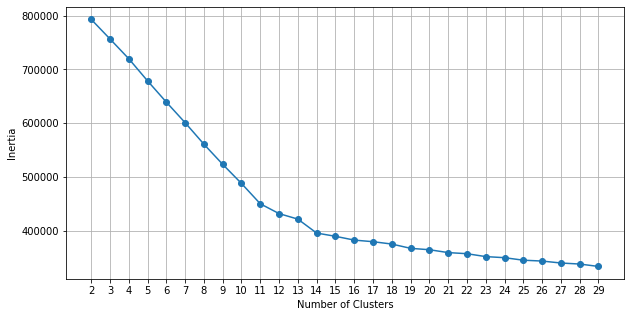

In [22]:
k_optimizer(X_train, 30)

Model using the ideal k from graph

In [23]:
kmeans = KMeans(n_clusters=10, random_state=876)
kmeans.fit(X_train)

KMeans(n_clusters=10, random_state=876)

In [24]:
cluster_count(kmeans.labels_)

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9
0,8991,3986,5022,2340,3989,3261,2870,2887,2515,754


In [25]:
(cluster_count(kmeans.labels_).sum()).sum()

36615

##### Run initial PCA to plot clusters

In [26]:
# Optain principal components
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Explained variance ratio:[0.08799046 0.06680751]
These components accounts for 15.48% of the variance


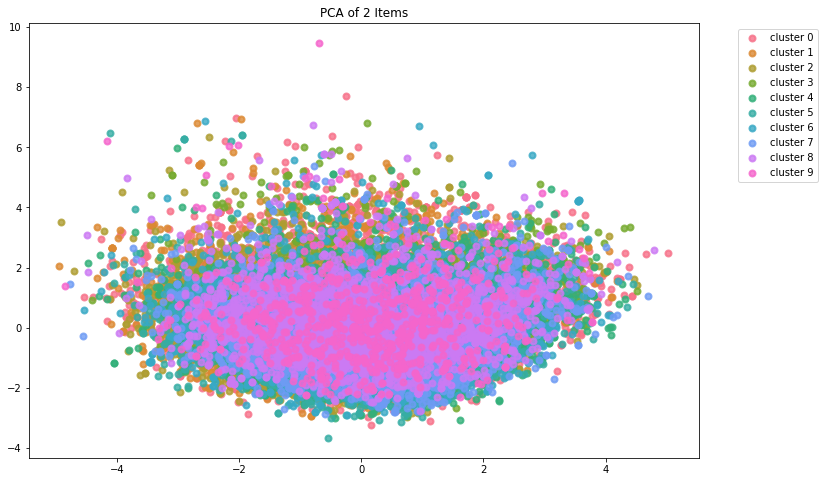

In [27]:
X_r = init_pca(X_train, kmeans.labels_,2)

##### Optimize PCA with the best number of components

Total Variance in our dataset is:  23.00062817501501
The 95% variance we want to have is:  21.850596766264257
20 n_components results in a variance of: 21.556335783509102


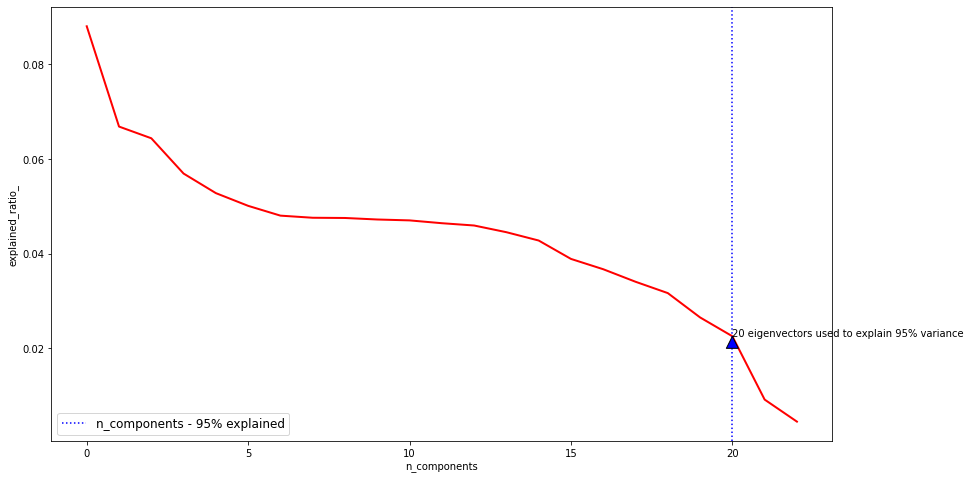

In [28]:
pca_optimizer(X_train)

##### Run PCA and Kmeans with optimized parameters

Explained variance ratio(first 20 components):[0.08799504 0.06682134 0.06435085 0.05690137 0.05277168 0.05008615
 0.04801837 0.04756999 0.0475232  0.04720371 0.0470142  0.04641986
 0.04593559 0.04452042 0.04276399 0.03888191 0.03670342 0.03405981
 0.03166549 0.02652787]
These 20 components represent 96.37% of the variance
The innertia for 2 Clusters is: 762574.5562452759
The innertia for 3 Clusters is: 725705.6184363383
The innertia for 4 Clusters is: 689734.3440856818
The innertia for 5 Clusters is: 647913.9372865468
The innertia for 6 Clusters is: 606548.0708320007
The innertia for 7 Clusters is: 568199.4489513698
The innertia for 8 Clusters is: 530515.2544001321
The innertia for 9 Clusters is: 493745.62780305627
The innertia for 10 Clusters is: 456497.82793402125
The innertia for 11 Clusters is: 420664.8831932711
The innertia for 12 Clusters is: 399474.2620641606
The innertia for 13 Clusters is: 387238.06914954074
The innertia for 14 Clusters is: 368669.3752067855
The innertia for 1

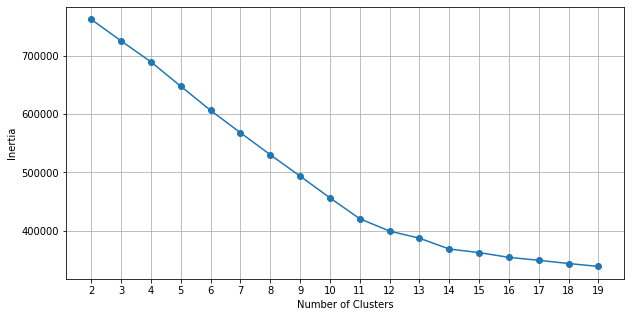

In [29]:
X_r = run_pca(X_train, 20)
k_optimizer(X_r, 20)

In [30]:
kmeans = KMeans(n_clusters=9, random_state=876)
kmeans.fit(X_r)

KMeans(n_clusters=9, random_state=876)

## Additional Data Optimization

In [31]:
df3 = df.drop(['artist_id',
         'artist_name', 
         'track_name', 
         'track_id', 
         'time_signature',
         'popularity'
        ],
        axis=1,
       )

In [32]:
df3['clusters'] = kmeans.labels_
df3.head(10)

,explicit,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
0,False,0.618,0.557,0.0,-5.227,0.0747,0.482000,0.2940,0.332,144.0,1.0,2021,2.703233,5
1,False,0.711,0.444,7.0,-7.602,0.2800,0.543000,0.1180,0.630,80.0,0.0,2021,3.622750,1
2,False,0.516,0.684,1.0,-5.736,0.0467,0.139000,0.1130,0.135,100.0,0.0,2021,3.716350,6
3,False,0.491,0.467,0.0,-9.551,0.0545,0.154000,0.1460,0.574,132.0,0.0,2021,3.245300,5
4,False,0.590,0.592,5.0,-7.909,0.2340,0.000575,0.4050,0.293,70.0,0.0,2021,3.257150,6
5,False,0.648,0.572,1.0,-7.416,0.3690,0.191000,0.0628,0.460,140.0,0.0,2021,2.511667,6
6,False,0.935,0.596,7.0,-5.642,0.1870,0.172000,0.1110,0.507,101.0,1.0,2022,2.732667,1
7,False,0.831,0.760,7.0,-6.073,0.2770,0.010800,0.0687,0.748,100.0,1.0,2022,2.171050,1
8,False,0.597,0.702,1.0,-4.602,0.1060,0.077100,0.5130,0.324,94.0,0.0,2021,2.537800,6
9,True,0.584,0.630,6.0,-7.131,0.2840,0.288000,0.1670,0.427,180.0,0.0,2022,3.238550,6


Inspect the different clusters

In [33]:
for i in range(9):
    display(df3[df3['clusters'] == i].describe())

,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,2870.000000,2870.00000,2870.0,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.0
mean,0.726171,0.59707,10.0,-8.721553,0.164962,0.191282,0.180371,0.718090,115.090941,0.340070,2011.442857,3.707145,0.0
std,0.116814,0.16866,0.0,3.794770,0.133170,0.220405,0.155093,0.190274,32.643470,0.473815,9.910406,1.271808,0.0
min,0.216000,0.08360,10.0,-32.408000,0.023900,0.000009,0.017000,0.079000,59.000000,0.000000,1965.000000,0.296050,0.0
25%,0.660000,0.47300,10.0,-11.070250,0.063300,0.025600,0.080600,0.610000,86.000000,0.000000,2008.000000,3.115550,0.0
50%,0.741000,0.59850,10.0,-8.053500,0.119000,0.102000,0.119500,0.758000,106.000000,0.000000,2014.000000,3.614775,0.0
75%,0.808000,0.72500,10.0,-5.830000,0.242750,0.278000,0.243000,0.866000,140.000000,1.000000,2019.000000,4.068242,0.0
max,0.978000,0.98400,10.0,-1.580000,0.947000,0.973000,0.982000,0.985000,218.000000,1.000000,2022.000000,35.702000,0.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,5022.000000,5022.00000,5022.0,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.0
mean,0.724396,0.60420,7.0,-8.565735,0.157416,0.183114,0.194869,0.688976,117.201712,0.802867,2011.571685,3.891366,1.0
std,0.116158,0.16892,0.0,3.752216,0.123415,0.210474,0.175361,0.188726,32.687383,0.397873,9.933815,2.151453,0.0
min,0.135000,0.02260,7.0,-28.556000,0.024200,0.000012,0.018300,0.036400,37.000000,0.000000,1965.000000,0.255783,1.0
25%,0.656000,0.48800,7.0,-10.869000,0.058600,0.025525,0.082625,0.565000,86.000000,1.000000,2008.000000,3.248221,1.0
50%,0.739000,0.61200,7.0,-7.814000,0.115000,0.098450,0.125000,0.710000,118.000000,1.000000,2014.000000,3.687083,1.0
75%,0.809000,0.72700,7.0,-5.769000,0.233000,0.267000,0.265000,0.840000,142.000000,1.000000,2019.000000,4.123667,1.0
max,0.965000,0.99800,7.0,-0.112000,0.959000,0.992000,0.999000,0.985000,212.000000,1.000000,2022.000000,60.274650,1.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,754.000000,754.000000,754.0,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.0
mean,0.701550,0.596934,3.0,-8.331516,0.141555,0.290065,0.187299,0.731686,118.082228,0.486737,2012.645889,3.503324,2.0
std,0.132349,0.168765,0.0,3.688761,0.135038,0.264460,0.165141,0.203507,32.419865,0.500156,9.054098,1.021017,0.0
min,0.316000,0.043000,3.0,-38.541000,0.025300,0.000057,0.028600,0.037300,64.000000,0.000000,1969.000000,0.275550,2.0
25%,0.615500,0.487250,3.0,-10.181500,0.047325,0.064575,0.091550,0.612750,86.000000,0.000000,2010.000000,2.907500,2.0
50%,0.722500,0.600000,3.0,-7.719000,0.083550,0.215000,0.124000,0.768000,118.000000,0.000000,2014.000000,3.475567,2.0
75%,0.801750,0.716000,3.0,-5.834000,0.207000,0.475000,0.219500,0.898750,141.000000,1.000000,2019.000000,3.979662,2.0
max,0.976000,0.965000,3.0,-1.463000,0.961000,0.977000,0.977000,0.984000,216.000000,1.000000,2022.000000,7.870967,2.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,2340.000000,2340.000000,2340.0,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.0
mean,0.709485,0.604871,4.0,-8.439553,0.162072,0.217171,0.203945,0.669022,117.469231,0.244872,2011.887179,3.841723,3.0
std,0.122704,0.171020,0.0,3.663499,0.127596,0.237071,0.178606,0.190376,32.923758,0.430103,9.449585,1.252203,0.0
min,0.271000,0.003020,4.0,-25.318000,0.024600,0.000005,0.016100,0.037000,36.000000,0.000000,1965.000000,0.250600,3.0
25%,0.641750,0.485000,4.0,-10.414750,0.061000,0.036750,0.087000,0.549750,85.000000,0.000000,2009.000000,3.255783,3.0
50%,0.726000,0.616000,4.0,-7.650500,0.117500,0.126500,0.131000,0.687000,120.000000,0.000000,2014.000000,3.715283,3.0
75%,0.798000,0.730000,4.0,-5.805750,0.238250,0.311250,0.288000,0.819000,143.000000,0.000000,2019.000000,4.194033,3.0
max,0.962000,0.998000,4.0,-0.785000,0.945000,0.994000,0.992000,0.985000,214.000000,1.000000,2022.000000,26.994450,3.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,2818.000000,2818.000000,2818.0,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,2818.00000,2818.000000,2818.000000,2818.000000,2818.0
mean,0.716817,0.609810,2.0,-8.370361,0.155161,0.196385,0.186464,0.675397,116.05110,0.824698,2011.941093,3.797878,4.0
std,0.118941,0.170517,0.0,3.710053,0.125362,0.218002,0.166402,0.206276,32.16519,0.380292,9.651033,1.671055,0.0
min,0.155000,0.025500,2.0,-28.226000,0.024500,0.000005,0.016300,0.034800,38.00000,0.000000,1969.000000,0.310967,4.0
25%,0.646000,0.493000,2.0,-10.706500,0.056125,0.024875,0.082400,0.539250,86.00000,1.000000,2009.000000,3.190450,4.0
50%,0.734000,0.620000,2.0,-7.722000,0.108000,0.115000,0.123000,0.713000,111.00000,1.000000,2014.000000,3.628758,4.0
75%,0.802000,0.737000,2.0,-5.628750,0.231000,0.300000,0.247000,0.841000,141.00000,1.000000,2019.000000,4.074667,4.0
max,0.980000,0.996000,2.0,0.160000,0.872000,0.991000,0.999000,0.984000,208.00000,1.000000,2022.000000,50.675033,4.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,3986.000000,3986.000000,3986.0,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.0
mean,0.715627,0.589250,0.0,-8.627166,0.135582,0.204330,0.191965,0.700125,118.671350,0.843954,2011.675113,3.839677,5.0
std,0.125978,0.168709,0.0,3.755883,0.119187,0.221204,0.176848,0.189654,31.516252,0.362945,9.956320,2.413968,0.0
min,0.180000,0.007070,0.0,-29.595000,0.024700,0.000005,0.018900,0.035800,39.000000,0.000000,1968.000000,0.304000,5.0
25%,0.645250,0.470000,0.0,-10.863250,0.049725,0.035600,0.084025,0.582000,89.000000,1.000000,2009.000000,3.189662,5.0
50%,0.734000,0.594500,0.0,-7.976000,0.087450,0.125000,0.121000,0.729000,121.000000,1.000000,2014.000000,3.644333,5.0
75%,0.806000,0.713000,0.0,-5.787250,0.187000,0.307000,0.245750,0.852000,143.000000,1.000000,2019.000000,4.089646,5.0
max,0.990000,0.973000,0.0,-0.292000,0.942000,0.995000,0.996000,0.986000,207.000000,1.000000,2022.000000,64.339933,5.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.000000,13049.0
mean,0.718677,0.611897,5.067975,-8.410373,0.162217,0.189138,0.186915,0.692557,117.435512,0.544410,2011.769714,3.761388,6.0
std,0.121287,0.170013,3.063735,3.768661,0.126669,0.211622,0.163720,0.196566,32.245352,0.498043,9.714127,1.790047,0.0
min,0.148000,0.000177,1.000000,-29.395000,0.023800,0.000003,0.011700,0.000010,36.000000,0.000000,1965.000000,0.283850,6.0
25%,0.648000,0.490000,1.000000,-10.645000,0.059800,0.029600,0.083500,0.566000,88.000000,0.000000,2009.000000,3.164183,6.0
50%,0.734000,0.625000,5.000000,-7.633000,0.121000,0.111000,0.123000,0.722000,115.000000,1.000000,2014.000000,3.633683,6.0
75%,0.805000,0.740000,9.000000,-5.641000,0.243000,0.274000,0.247000,0.851000,142.000000,1.000000,2019.000000,4.066667,6.0
max,0.983000,0.996000,9.000000,-0.167000,0.957000,0.995000,0.999000,0.998000,214.000000,1.000000,2022.000000,61.885450,6.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,2515.000000,2515.000000,2515.0,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.0
mean,0.713566,0.600953,8.0,-8.337061,0.160013,0.223277,0.177910,0.714394,116.313718,0.702187,2012.217495,3.647448,7.0
std,0.120711,0.168954,0.0,3.704968,0.126784,0.221236,0.149041,0.190484,32.231237,0.457388,9.610845,1.800475,0.0
min,0.117000,0.051700,8.0,-29.753000,0.025000,0.000017,0.020700,0.028500,37.000000,0.000000,1965.000000,0.288117,7.0
25%,0.643000,0.480000,8.0,-10.574500,0.057800,0.045000,0.084250,0.596000,87.000000,0.000000,2009.000000,3.070050,7.0
50%,0.725000,0.603000,8.0,-7.707000,0.113000,0.151000,0.123000,0.742000,112.000000,1.000000,2015.000000,3.537150,7.0
75%,0.801000,0.728000,8.0,-5.581000,0.238000,0.337000,0.233000,0.870000,142.000000,1.000000,2019.000000,3.993150,7.0
max,0.969000,0.982000,8.0,-0.240000,0.911000,0.993000,0.999000,0.989000,217.000000,1.000000,2022.000000,54.551333,7.0


,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration,clusters
count,3261.000000,3261.000000,3261.0,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.0
mean,0.729294,0.599582,11.0,-8.781953,0.162121,0.151818,0.186911,0.683126,119.499233,0.355412,2011.842073,3.837194,8.0
std,0.116649,0.172809,0.0,3.886163,0.124020,0.184236,0.163902,0.187094,31.959173,0.478712,9.550699,1.633831,0.0
min,0.159000,0.047900,11.0,-31.737000,0.024400,0.000010,0.019000,0.033800,59.000000,0.000000,1968.000000,0.281267,8.0
25%,0.662000,0.479000,11.0,-11.115000,0.061500,0.016800,0.084700,0.563000,90.000000,0.000000,2008.000000,3.240100,8.0
50%,0.746000,0.612000,11.0,-7.952000,0.117000,0.075400,0.120000,0.701000,124.000000,0.000000,2014.000000,3.672667,8.0
75%,0.813000,0.731000,11.0,-5.960000,0.242000,0.223000,0.249000,0.831000,142.000000,1.000000,2019.000000,4.131100,8.0
max,0.979000,0.976000,11.0,0.152000,0.917000,0.900000,0.993000,0.987000,245.000000,1.000000,2022.000000,50.347917,8.0


Observation of the clusters show that there is a distinct separation by the key of the track and that does not represent the genre of the track.
The key of a song can be assumed to be randomly generated for every genre and is not a genre specific feature. This means that it will be removed from the dataframe.

In [34]:
df3 = df.drop(['artist_id',
         'artist_name', 
         'track_name', 
         'track_id', 
         'key',
         'time_signature',
         'popularity',
        ],
        axis=1,
       )

In [35]:
df3['mode'] = df3['mode'].replace([1],'major')
df3['mode'] = df3['mode'].replace([0],'minor')

df3['explicit'] = df3['explicit'].replace([True],'explicit')
df3['explicit'] = df3['explicit'].replace([False],'clean')
df3.head(10)

,explicit,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,mode,release_year,duration
0,clean,0.618,0.557,-5.227,0.0747,0.482000,0.2940,0.332,144.0,major,2021,2.703233
1,clean,0.711,0.444,-7.602,0.2800,0.543000,0.1180,0.630,80.0,minor,2021,3.622750
2,clean,0.516,0.684,-5.736,0.0467,0.139000,0.1130,0.135,100.0,minor,2021,3.716350
3,clean,0.491,0.467,-9.551,0.0545,0.154000,0.1460,0.574,132.0,minor,2021,3.245300
4,clean,0.590,0.592,-7.909,0.2340,0.000575,0.4050,0.293,70.0,minor,2021,3.257150
5,clean,0.648,0.572,-7.416,0.3690,0.191000,0.0628,0.460,140.0,minor,2021,2.511667
6,clean,0.935,0.596,-5.642,0.1870,0.172000,0.1110,0.507,101.0,major,2022,2.732667
7,clean,0.831,0.760,-6.073,0.2770,0.010800,0.0687,0.748,100.0,major,2022,2.171050
8,clean,0.597,0.702,-4.602,0.1060,0.077100,0.5130,0.324,94.0,minor,2021,2.537800
9,explicit,0.584,0.630,-7.131,0.2840,0.288000,0.1670,0.427,180.0,minor,2022,3.238550


In [36]:
columns = ['mode', 'explicit']
df3 = one_hot_encode(columns, df3)
df3.head()

mode
explicit


,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_year,duration,minor,explicit
0,0.618,0.557,-5.227,0.0747,0.482000,0.294,0.332,144.0,2021,2.703233,0,0
1,0.711,0.444,-7.602,0.2800,0.543000,0.118,0.630,80.0,2021,3.622750,1,0
2,0.516,0.684,-5.736,0.0467,0.139000,0.113,0.135,100.0,2021,3.716350,1,0
3,0.491,0.467,-9.551,0.0545,0.154000,0.146,0.574,132.0,2021,3.245300,1,0
4,0.590,0.592,-7.909,0.2340,0.000575,0.405,0.293,70.0,2021,3.257150,1,0


In [37]:
scaler = StandardScaler()
X_train_2 = scaler.fit_transform(df3)
X_train_2 = pd.DataFrame(X_train_2, columns=[df3.columns])

In [38]:
X_train_2

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_year,duration,minor,explicit
0,-0.839367,-0.279078,0.871124,-0.658248,1.334464,0.633520,-1.863432,0.824739,0.947129,-0.591922,-0.830694,-0.273715
1,-0.068225,-0.943723,0.239950,0.969211,1.616702,-0.423203,-0.327460,-1.157350,0.947129,-0.088799,1.203812,-0.273715
2,-1.685135,0.467913,0.735853,-0.880210,-0.252546,-0.453224,-2.878823,-0.537947,0.947129,-0.037584,1.203812,-0.273715
3,-1.892431,-0.808441,-0.278010,-0.818378,-0.183143,-0.255088,-0.616099,0.453097,0.947129,-0.295324,1.203812,-0.273715
4,-1.071539,-0.073214,0.158363,0.604559,-0.893018,1.299976,-2.064448,-1.467051,0.947129,-0.288841,1.203812,-0.273715
...,...,...,...,...,...,...,...,...,...,...,...,...
36610,0.495620,-0.449650,0.659050,-0.961068,-0.321949,-0.555293,-0.657333,-0.599888,0.741621,-0.457083,-0.830694,-0.273715
36611,0.255156,0.444386,0.778640,0.247834,0.723720,-0.237076,0.342595,0.422127,0.741621,-0.561345,-0.830694,-0.273715
36612,-1.502715,0.138532,0.214969,2.110731,1.811030,-0.576308,-1.389239,-1.559962,0.741621,-0.473316,1.203812,-0.273715
36613,-0.549152,-0.026159,-0.056369,0.311251,-0.807768,-0.817673,0.579691,-0.599888,0.741621,-0.842704,1.203812,-0.273715


The innertia for 2 Clusters is: 390561.71055488853
The innertia for 3 Clusters is: 353390.99281097937
The innertia for 4 Clusters is: 329838.82450715214
The innertia for 5 Clusters is: 308605.63045740715
The innertia for 6 Clusters is: 289369.8392654375
The innertia for 7 Clusters is: 272650.9485088545
The innertia for 8 Clusters is: 256749.75167688975
The innertia for 9 Clusters is: 246827.15919440865
The innertia for 10 Clusters is: 237941.44874982894
The innertia for 11 Clusters is: 231203.70018596994
The innertia for 12 Clusters is: 225343.73952355827
The innertia for 13 Clusters is: 219931.0416938451
The innertia for 14 Clusters is: 215266.0244335646
The innertia for 15 Clusters is: 209941.7159795944
The innertia for 16 Clusters is: 206522.42710403207
The innertia for 17 Clusters is: 203203.83500582151
The innertia for 18 Clusters is: 200564.57816728018
The innertia for 19 Clusters is: 197872.0634492241


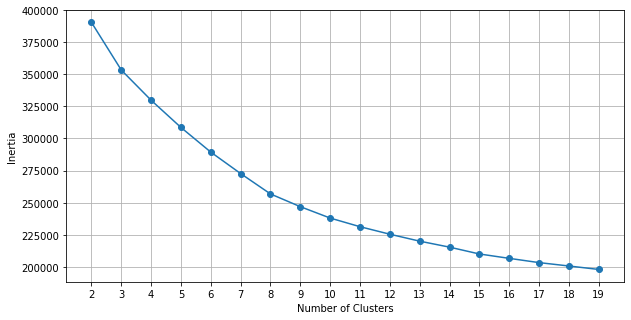

In [39]:
k_optimizer(X_train_2, 20)

In [40]:
kmeans2 = KMeans(n_clusters=6, random_state=876)
kmeans2.fit(X_train_2)

KMeans(n_clusters=6, random_state=876)

In [41]:
# Get the number of values within each cluster
cluster_count(kmeans2.labels_)

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5
0,9555,11705,3819,43,2543,8950


Explained variance ratio:[0.16787444 0.12753453]
These components accounts for 29.54% of the variance


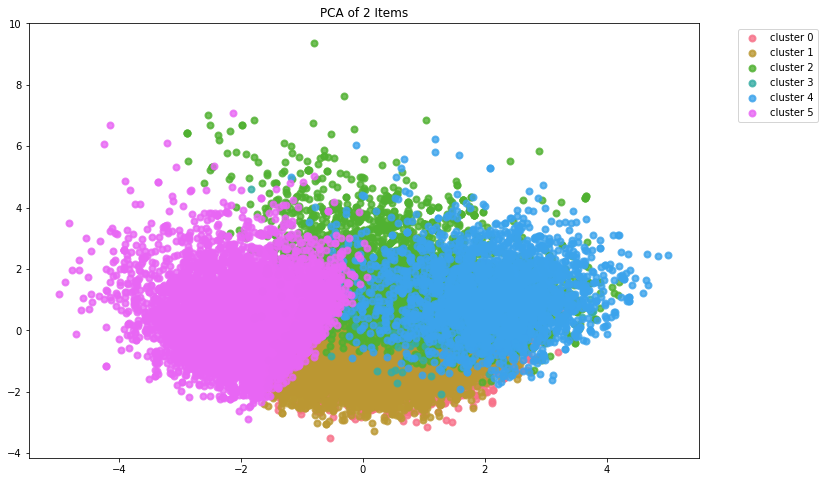

In [42]:
X_r2 = init_pca(X_train_2, kmeans2.labels_,2)

Optimize PCA

Total Variance in our dataset is:  12.000327743486103
The 95% variance we want to have is:  11.400311356311798
11 n_components results in a variance of: 11.265399241216938


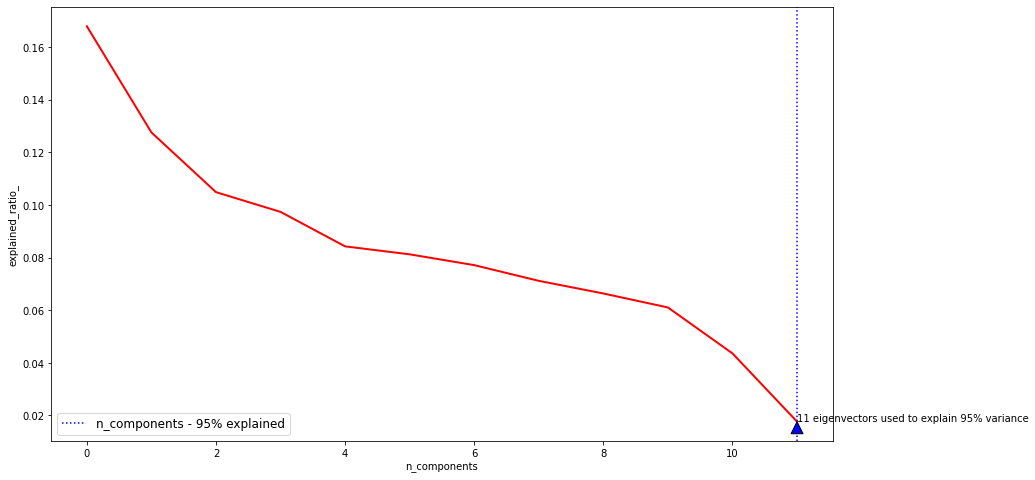

In [43]:
pca_optimizer(X_train_2)

Explained variance ratio(first 11 components):[0.16787444 0.12753453 0.10485445 0.0973534  0.08424925 0.08122578
 0.07712091 0.07115308 0.0663519  0.06103989 0.04358142]
These 11 components represent 98.23% of the variance
The innertia for 2 Clusters is: 382813.0156135471
The innertia for 3 Clusters is: 345640.18414010707
The innertia for 4 Clusters is: 322084.78447487747
The innertia for 5 Clusters is: 300865.3857094095
The innertia for 6 Clusters is: 283288.45523943997
The innertia for 7 Clusters is: 264318.6874537518
The innertia for 8 Clusters is: 249003.82964137505
The innertia for 9 Clusters is: 239312.96390010323
The innertia for 10 Clusters is: 230234.42246865842
The innertia for 11 Clusters is: 223501.34626037648
The innertia for 12 Clusters is: 217536.8216874838
The innertia for 13 Clusters is: 212253.3796620017
The innertia for 14 Clusters is: 207569.59557085793
The innertia for 15 Clusters is: 202262.43174675165
The innertia for 16 Clusters is: 198806.3846638577
The innerti

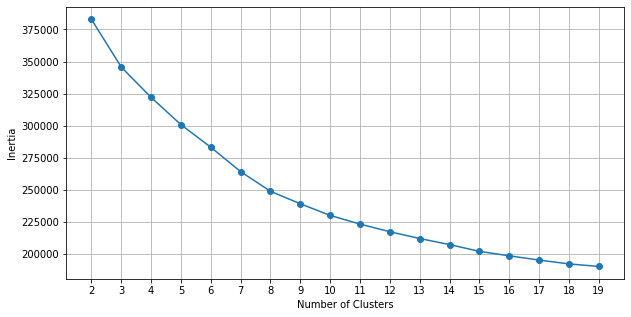

In [44]:
X_r2 = run_pca(X_train_2, 11)
k_optimizer(X_r2, 20)

In [45]:
kmeans2 = KMeans(n_clusters=6, random_state=876)
kmeans2.fit(X_r2)

KMeans(n_clusters=6, random_state=876)

In [46]:
df4 = df.copy()

In [47]:
df4['clusters'] = kmeans2.labels_

Analyze Clusters

In [48]:
cluster_count(kmeans2.labels_)

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5
0,8049,2545,9870,43,3992,12116


In [49]:
for i in range(6):
    df_describe = df4[df4['clusters'] == i].loc[:,['release_year','mode', 'duration']].describe()
    df_describe = pd.pivot_table(df_describe, columns = list(df_describe.index))
    
    display(
        df_describe
    )

,25%,50%,75%,count,max,mean,min,std
duration,3.106883,3.5902,3.997333,8049.0,17.999117,3.663630,0.252217,1.212719
mode,0.000000,1.0000,1.000000,8049.0,1.000000,0.703690,0.000000,0.456658
release_year,2012.000000,2015.0000,2019.000000,8049.0,2022.000000,2014.758355,1986.000000,5.171956


,25%,50%,75%,count,max,mean,min,std
duration,2.7816,3.2,3.64155,2545.0,10.62975,3.249040,0.27555,0.775552
mode,0.0000,1.0,1.00000,2545.0,1.00000,0.513163,0.00000,0.499925
release_year,2015.0000,2019.0,2021.00000,2545.0,2022.00000,2017.482908,1991.00000,5.100850


,25%,50%,75%,count,max,mean,min,std
duration,3.301783,3.75,4.254392,9870.0,23.972,3.899802,0.29605,1.213264
mode,0.000000,0.00,0.000000,9870.0,0.000,0.000000,0.00000,0.000000
release_year,2011.000000,2015.00,2019.000000,9870.0,2022.000,2014.209726,1987.00000,5.798014


,25%,50%,75%,count,max,mean,min,std
duration,35.340933,43.689567,52.38615,43.0,64.339933,44.561575,25.72105,10.834811
mode,1.000000,1.000000,1.00000,43.0,1.000000,0.883721,0.00000,0.324353
release_year,2017.500000,2019.000000,2021.00000,43.0,2022.000000,2017.581395,1983.00000,6.359217


,25%,50%,75%,count,max,mean,min,std
duration,3.367333,3.743108,4.148667,3992.0,13.58445,3.846017,0.588,0.936133
mode,0.000000,1.000000,1.000000,3992.0,1.00000,0.636523,0.000,0.481061
release_year,1985.000000,1992.000000,1997.000000,3992.0,2009.00000,1990.144539,1965.000,8.688888


,25%,50%,75%,count,max,mean,min,std
duration,3.177158,3.626667,4.061529,12116.0,17.2739,3.719988,0.2506,1.053116
mode,1.000000,1.000000,1.000000,12116.0,1.0000,1.000000,1.0000,0.000000
release_year,2010.000000,2014.000000,2019.000000,12116.0,2022.0000,2013.739848,1987.0000,5.905809


In [50]:
# df4.to_csv('tracks_classified_2.csv', index=False)

## Additional Data Optimization 2

- Release Year will be removed because the genre does change over the years and some of the years represent when the song was uploaded on spotify and not the actual release date for the track.

- The duration is drastically affecting the classification, so it will be removed in this stage.

- All other categorical values will be removed to determine how the classification works when limited to continuous features.

In [51]:
df5 = df.drop(['artist_id',
         'artist_name', 
         'track_name', 
         'track_id', 
         'key',
         'time_signature',
         'popularity',
         'release_year',
         'duration',
         'mode',
         'explicit',
         'tempo',
        ],
        axis=1,
       )

In [52]:
scaler = StandardScaler()
X_train_3 = scaler.fit_transform(df5)
X_train_3 = pd.DataFrame(X_train_3, columns=[df5.columns])

In [53]:
X_train_3

,danceability,energy,loudness,speechiness,acousticness,liveness,valence
0,-0.839367,-0.279078,0.871124,-0.658248,1.334464,0.633520,-1.863432
1,-0.068225,-0.943723,0.239950,0.969211,1.616702,-0.423203,-0.327460
2,-1.685135,0.467913,0.735853,-0.880210,-0.252546,-0.453224,-2.878823
3,-1.892431,-0.808441,-0.278010,-0.818378,-0.183143,-0.255088,-0.616099
4,-1.071539,-0.073214,0.158363,0.604559,-0.893018,1.299976,-2.064448
...,...,...,...,...,...,...,...
36610,0.495620,-0.449650,0.659050,-0.961068,-0.321949,-0.555293,-0.657333
36611,0.255156,0.444386,0.778640,0.247834,0.723720,-0.237076,0.342595
36612,-1.502715,0.138532,0.214969,2.110731,1.811030,-0.576308,-1.389239
36613,-0.549152,-0.026159,-0.056369,0.311251,-0.807768,-0.817673,0.579691


The innertia for 2 Clusters is: 210922.53638106908
The innertia for 3 Clusters is: 185498.79943224345
The innertia for 4 Clusters is: 167443.7036084653
The innertia for 5 Clusters is: 151960.8351839003
The innertia for 6 Clusters is: 139909.76809373076
The innertia for 7 Clusters is: 132449.23086270352
The innertia for 8 Clusters is: 125642.17093231773
The innertia for 9 Clusters is: 119909.70053578376
The innertia for 10 Clusters is: 114916.96672326335
The innertia for 11 Clusters is: 111649.49043545697
The innertia for 12 Clusters is: 108698.78694604931
The innertia for 13 Clusters is: 105622.16963888326
The innertia for 14 Clusters is: 103234.03441409122
The innertia for 15 Clusters is: 100780.2662353962
The innertia for 16 Clusters is: 98658.70446134763
The innertia for 17 Clusters is: 96454.64143971945
The innertia for 18 Clusters is: 94567.24811662664
The innertia for 19 Clusters is: 93027.05058120693


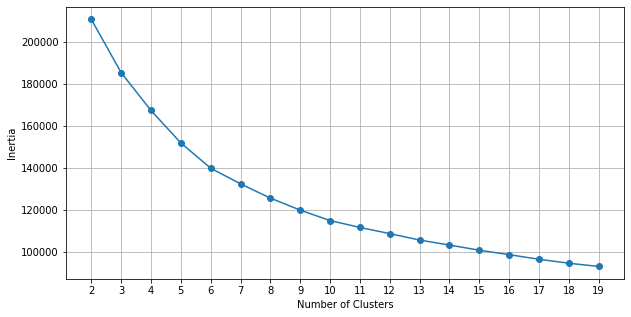

In [54]:
k_optimizer(X_train_3, 20)

In [55]:
kmeans3 = KMeans(n_clusters=4, random_state=876)
kmeans3.fit(X_train_3)

KMeans(n_clusters=4, random_state=876)

In [56]:
# Get the number of values within each cluster
cluster_count(kmeans3.labels_)

,cluster 0,cluster 1,cluster 2,cluster 3
0,13656,9460,9234,4265


Explained variance ratio:[0.26562376 0.21075555]
These components accounts for 47.64% of the variance


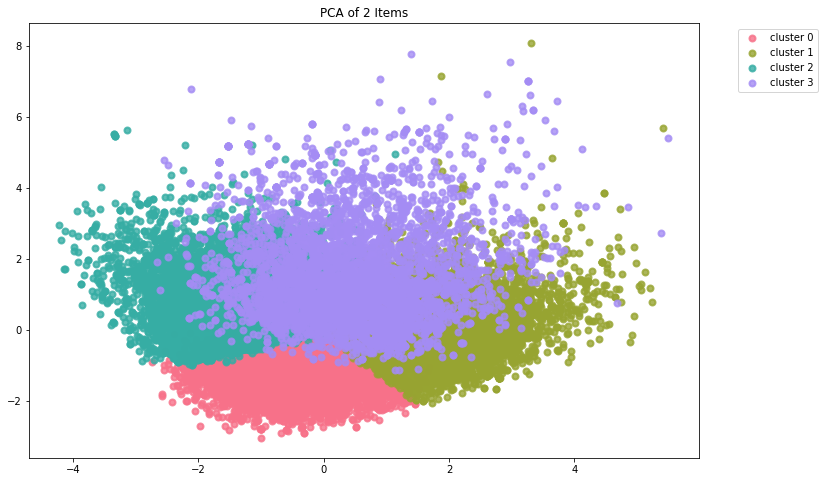

In [57]:
X_r3 = init_pca(X_train_3, kmeans3.labels_,2)

Optimize PCA

Total Variance in our dataset is:  7.000191183700233
The 95% variance we want to have is:  6.650181624515221
6 n_components results in a variance of: 6.225438371688269


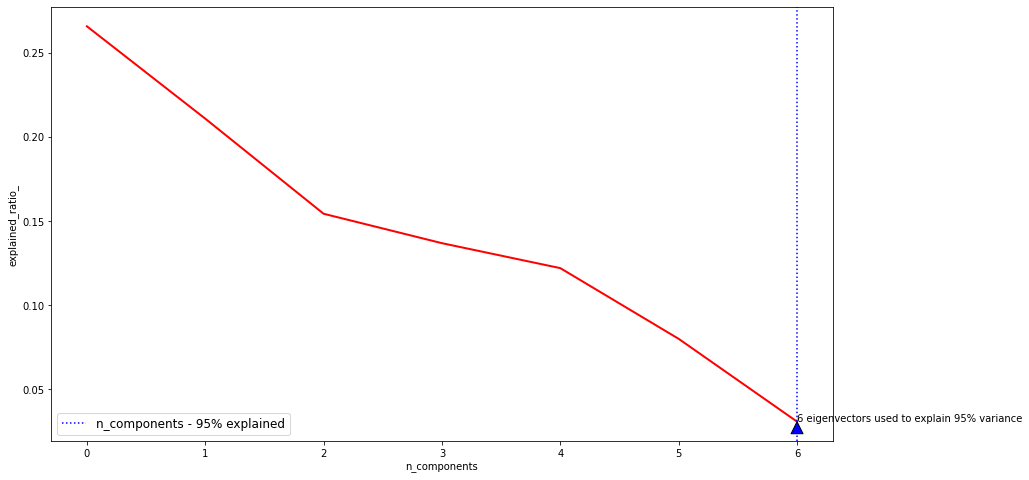

In [58]:
pca_optimizer(X_train_3)

Explained variance ratio(first 7 components):[0.26562376 0.21075555 0.15424794 0.13676177 0.12193503 0.07992914
 0.03074681]
These 7 components represent 100.0% of the variance
The innertia for 2 Clusters is: 210922.5363810691
The innertia for 3 Clusters is: 185498.7994322435
The innertia for 4 Clusters is: 167443.70360846535
The innertia for 5 Clusters is: 151960.83518390034
The innertia for 6 Clusters is: 139909.7680937308
The innertia for 7 Clusters is: 132449.23086270352
The innertia for 8 Clusters is: 125642.17093231773
The innertia for 9 Clusters is: 119909.70053578378
The innertia for 10 Clusters is: 114916.9667232634
The innertia for 11 Clusters is: 111649.49043545696
The innertia for 12 Clusters is: 108698.78694604934
The innertia for 13 Clusters is: 105622.16963888328
The innertia for 14 Clusters is: 103234.03441409125
The innertia for 15 Clusters is: 100780.26623539621
The innertia for 16 Clusters is: 98658.70446134765
The innertia for 17 Clusters is: 96454.64143971945
The i

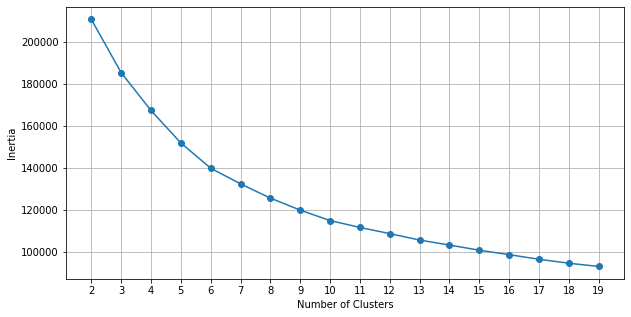

In [59]:
X_r3 = run_pca(X_train_3, 7)
k_optimizer(X_r3, 20)

In [60]:
kmeans3 = KMeans(n_clusters=4, random_state=876)
kmeans3.fit(X_r3)

KMeans(n_clusters=4, random_state=876)

In [61]:
df6 = df.copy()

In [62]:
df6['clusters'] = kmeans3.labels_

Analyze Clusters

In [63]:
cluster_count(kmeans3.labels_)

,cluster 0,cluster 1,cluster 2,cluster 3
0,13656,9460,9234,4265


In [67]:
for i in range(4):
    df_describe2 = df6[df6['clusters'] == i].describe()
    # df_describe2 = pd.pivot_table(df_describe2, columns = list(df_describe2.index))
    display(
        df_describe2
    )

,popularity,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration,clusters
count,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.0
mean,9.714631,0.771650,0.687191,5.576377,-6.689346,0.119746,0.139062,0.139880,0.788429,118.073887,4.005931,0.583407,2011.591095,3.753357,0.0
std,12.337844,0.081142,0.110851,3.597798,2.078122,0.090848,0.137164,0.096595,0.135570,30.212869,0.160674,0.493012,9.551681,1.186960,0.0
min,0.000000,0.444000,0.302000,0.000000,-14.925000,0.023900,0.000005,0.011700,0.195000,37.000000,1.000000,0.000000,1965.000000,0.471067,0.0
25%,1.000000,0.717000,0.603000,2.000000,-8.025000,0.050200,0.028200,0.073075,0.701000,91.000000,4.000000,0.000000,2008.000000,3.234450,0.0
50%,4.000000,0.773000,0.682000,6.000000,-6.554000,0.083500,0.095000,0.105000,0.811000,120.000000,4.000000,1.000000,2014.000000,3.673300,0.0
75%,15.000000,0.830000,0.766000,9.000000,-5.230000,0.167000,0.211000,0.176000,0.898000,141.000000,4.000000,1.000000,2019.000000,4.102450,0.0
max,75.000000,0.990000,0.997000,11.000000,0.160000,0.583000,0.768000,0.770000,0.997000,214.000000,5.000000,1.000000,2022.000000,60.010617,0.0


,popularity,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration,clusters
count,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.000000,9460.0
mean,5.904440,0.774658,0.426251,5.721459,-12.720639,0.165671,0.104176,0.136744,0.687226,117.668605,4.000211,0.612156,2009.468499,3.813530,1.0
std,9.342705,0.084054,0.100851,3.652107,3.091811,0.125639,0.117639,0.104906,0.181813,32.849499,0.162572,0.487284,11.329292,1.244631,0.0
min,0.000000,0.290000,0.022600,0.000000,-38.541000,0.024300,0.000010,0.014900,0.028500,37.000000,1.000000,0.000000,1967.000000,0.275550,1.0
25%,0.000000,0.724000,0.362000,2.000000,-14.514250,0.068600,0.013575,0.072800,0.566750,84.000000,4.000000,0.000000,2005.000000,3.285333,1.0
50%,2.000000,0.781000,0.431000,6.000000,-12.433000,0.121000,0.057200,0.102000,0.704000,123.000000,4.000000,1.000000,2014.000000,3.677117,1.0
75%,8.000000,0.834000,0.495000,9.000000,-10.498000,0.235000,0.160000,0.157000,0.832000,143.000000,4.000000,1.000000,2018.000000,4.053008,1.0
max,83.000000,0.983000,0.882000,11.000000,-5.327000,0.959000,0.677000,0.988000,0.998000,210.000000,5.000000,1.000000,2022.000000,40.806200,1.0


,popularity,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration,clusters
count,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.000000,9234.0
mean,11.158003,0.613631,0.717299,5.410115,-6.224286,0.202483,0.156637,0.297204,0.566029,117.372428,4.040719,0.552632,2014.114143,3.958833,2.0
std,12.516609,0.106672,0.119500,3.568335,2.289558,0.133142,0.149181,0.223550,0.189708,34.405870,0.425125,0.497249,7.112073,2.854258,0.0
min,0.000000,0.117000,0.215000,0.000000,-18.044000,0.023800,0.000003,0.017000,0.034800,36.000000,1.000000,0.000000,1969.000000,0.250600,2.0
25%,1.000000,0.548000,0.633000,2.000000,-7.620000,0.078000,0.030400,0.122000,0.433000,87.000000,4.000000,0.000000,2011.000000,3.151117,2.0
50%,7.000000,0.621000,0.719000,6.000000,-5.983000,0.192000,0.113000,0.242000,0.575000,108.000000,4.000000,1.000000,2016.000000,3.640658,2.0
75%,18.000000,0.687750,0.806000,8.000000,-4.634500,0.300000,0.247000,0.371000,0.707000,144.000000,4.000000,1.000000,2020.000000,4.162154,2.0
max,85.000000,0.918000,0.998000,11.000000,0.152000,0.950000,0.871000,0.999000,0.981000,245.000000,5.000000,1.000000,2022.000000,64.339933,2.0


,popularity,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration,clusters
count,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.000000,4265.0
mean,7.230246,0.657055,0.490431,5.393200,-9.904964,0.164899,0.646451,0.223497,0.679721,114.447597,3.953341,0.657444,2012.480422,3.447017,3.0
std,10.147481,0.140944,0.149725,3.512895,3.462068,0.166331,0.163187,0.188063,0.220877,32.590970,0.473430,0.474620,10.129261,1.705496,0.0
min,0.000000,0.148000,0.000177,0.000000,-32.408000,0.024600,0.203000,0.022900,0.000010,36.000000,1.000000,0.000000,1965.000000,0.252217,3.0
25%,0.000000,0.578000,0.396000,2.000000,-11.762000,0.047000,0.520000,0.105000,0.535000,85.000000,4.000000,0.000000,2010.000000,2.728450,3.0
50%,3.000000,0.674000,0.497000,6.000000,-9.555000,0.093100,0.642000,0.146000,0.723000,109.000000,4.000000,1.000000,2015.000000,3.333867,3.0
75%,10.000000,0.756000,0.590000,8.000000,-7.411000,0.237000,0.773000,0.289000,0.860000,138.000000,4.000000,1.000000,2019.000000,3.922667,3.0
max,69.000000,0.957000,0.961000,11.000000,-1.615000,0.961000,0.995000,0.993000,0.987000,216.000000,5.000000,1.000000,2022.000000,61.885450,3.0


In [68]:
df6.head()

,artist_id,artist_name,track_name,track_id,popularity,explicit,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,time_signature,mode,release_year,duration,clusters
0,2O6ph9RDudyvAR4Gj6VDoE,$wizzz,L.I.F.E,0eyJ7wobiSnBiviFjDD4WV,13,False,0.618,0.557,0.0,-5.227,0.0747,0.482000,0.294,0.332,144.0,4.0,1.0,2021,2.703233,2
1,2O6ph9RDudyvAR4Gj6VDoE,$wizzz,G-spot,0n5HmWeoStEZzxdu4DFiBv,10,False,0.711,0.444,7.0,-7.602,0.2800,0.543000,0.118,0.630,80.0,4.0,0.0,2021,3.622750,3
2,2O6ph9RDudyvAR4Gj6VDoE,$wizzz,High grade,19BuQIrARlDVkOgY06BuP2,10,False,0.516,0.684,1.0,-5.736,0.0467,0.139000,0.113,0.135,100.0,4.0,0.0,2021,3.716350,2
3,2O6ph9RDudyvAR4Gj6VDoE,$wizzz,Story,4Fvl6HcI4kfiACcelfWhkw,10,False,0.491,0.467,0.0,-9.551,0.0545,0.154000,0.146,0.574,132.0,5.0,0.0,2021,3.245300,2
4,2O6ph9RDudyvAR4Gj6VDoE,$wizzz,Bubble,4VJMkS6IEdG7pN8UpJugvT,12,False,0.590,0.592,5.0,-7.909,0.2340,0.000575,0.405,0.293,70.0,3.0,0.0,2021,3.257150,2


In [69]:
df6.to_csv('Files/tracks_classified.csv', index=False)